## Transformer Failure Prediction

### About  
Transformers plays a very important role in the power system. Though they are some of the most reliable component of the electrical grid they are also prone to failure due to many factors both internal or external. There could be many initiators which cause a transformer failure, but those which can potentially lead to catastrophic failure are the following:
- Mechanical Failure
- Dielectric Failure

### Content 
This data is collected via IoT devices from June 25th, 2019 to April 14th, 2020 which was updated every 15 minutes.
Parameters Description:

CurrentVoltage:
- VL1- Phase Line 1
- VL2- Phase Line 2
- VL3- Phase Line 3
- IL1- Current Line 1
- IL2- Current Line 2
- IL3- Current Line 3
- VL12- Voltage line 1 2
- VL23- Voltage line 2 3
- VL31- Voltage line 3 1
- INUT- Neutral Current

Overview:
- OTI- Oil Temperature Indicator
- WTI- Winding Temperature Indicator
- ATI- Ambient Temperature Indicator
- OLI- Oil Level Indicator
- OTI_A- Oil Temperature Indicator Alarm
- OTI_T- Oil Temperature Indicator Trip
- MOG_A- Magnetic oil gauge indicator

### Table of Contents

1. [Data Preparation](#data-preparation)
    - [Import Libraries](#import-libraries)
    - [Load Datasets](#load-datasets)
    - [Prep Summary](#prep-summary)
2. [Data Cleaning and Processing](#data-cleaning-and-processing)
    - [Null Detection / Imputation](#null-detection--imputation)
    - [DateTime](#datetime)
3. [EDA (Exploratory Data Analysis)](#eda)
    - [Correlations](#correlations)
    - [Visualizations](#visualizations)
4. [Model Selection]
5. [Modeling and Predictions]

## Data Preparation

### Import Libraries

In [48]:
# PROCESSING
import numpy as np
import pandas as pd
import functools

# VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns

# SYSTEM
import os
import time
import pickle

# MODELING
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, RandomizedSearchCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# SETTINGS
pd.set_option("display.max_columns", 20)
plt.style.use('ggplot')

# DIRECTORIES
DATA_DIR = os.path.join(os.path.abspath(os.curdir), 'kaggle', 'input', 'ai-transformer-monitoring')
OVERVIEW_PATH = os.path.join(DATA_DIR, 'Overview.csv')
CURRENT_VOLTAGE = os.path.join(DATA_DIR, 'CurrentVoltage.csv')
POWER_PATH = os.path.join(DATA_DIR, 'Power.csv')
POWER_FACTOR = os.path.join(DATA_DIR, 'PowerFactor.csv')
TOTAL_POWER = os.path.join(DATA_DIR, 'TotalPower.csv')

### Load Datasets

In [2]:
df_overview = pd.read_csv(OVERVIEW_PATH)
df_overview

,DeviceTimeStamp,OTI,WTI,ATI,OLI,OTI_A,OTI_T,MOG_A
0,2019-06-25T13:06,0.0,0.0,0.0,37.0,0.0,0.0,0.0
1,2019-06-25T13:09,0.0,0.0,0.0,37.0,0.0,0.0,0.0
2,2019-06-27T10:49,0.0,0.0,0.0,38.0,0.0,0.0,0.0
3,2019-06-27T10:51,0.0,0.0,0.0,38.0,0.0,0.0,0.0
4,2019-06-27T10:52,0.0,0.0,0.0,39.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
20311,2020-04-13T23:30,31.0,1.0,28.0,100.0,0.0,0.0,0.0
20312,2020-04-13T23:45,31.0,1.0,28.0,100.0,0.0,0.0,0.0
20313,2020-04-14T00:00,31.0,1.0,28.0,100.0,0.0,0.0,0.0
20314,2020-04-14T00:15,30.0,1.0,28.0,100.0,0.0,0.0,0.0


In [3]:
df_currvolt = pd.read_csv(CURRENT_VOLTAGE)
df_currvolt

,DeviceTimeStamp,VL1,VL2,VL3,IL1,IL2,IL3,VL12,VL23,VL31,INUT
0,2019-06-25T13:06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-06-27T10:49,238.7,238.7,238.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-06-27T10:51,238.4,238.5,238.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-06-27T10:52,239.9,240.0,240.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-06-27T10:52,239.9,240.0,240.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
19347,2020-04-13T23:30,246.4,244.7,244.3,79.0,45.4,86.6,426.0,422.3,426.1,38.0
19348,2020-04-13T23:45,246.8,245.1,244.8,77.0,42.0,84.2,426.8,423.1,427.1,39.1
19349,2020-04-14T00:00,247.8,246.0,246.0,77.4,37.1,75.4,428.5,425.0,428.7,38.8
19350,2020-04-14T00:15,247.7,245.9,245.5,70.1,36.7,88.1,428.2,424.3,428.4,45.2


In [4]:
targets = ['WTI', 'OTI_A', 'OTI_T', 'MOG_A']

### Summary

- 19248 (from *TotalPower.csv*) is the minimum number of rows from each dataset
- 4 potential target attributes for binary classification (failure/no failure)
  - *Overview.csv*
    - `WTI`: Winding Temperature Indicator
    - `OTI_A`: Oil Temperature Indicator Alarm
    - `OTI_T`: Oil Temperature Indicator Trip
    - `MOG_A`: Magnetic Oil Gauge Indicator

## Data Cleaning and Processing

### Null Detection / Imputation

In [5]:
df_overview.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20316 entries, 0 to 20315
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DeviceTimeStamp  20316 non-null  object 
 1   OTI              20316 non-null  float64
 2   WTI              20316 non-null  float64
 3   ATI              20316 non-null  float64
 4   OLI              20316 non-null  float64
 5   OTI_A            20316 non-null  float64
 6   OTI_T            20316 non-null  float64
 7   MOG_A            20316 non-null  float64
dtypes: float64(7), object(1)
memory usage: 1.2+ MB


In [6]:
df_currvolt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19352 entries, 0 to 19351
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DeviceTimeStamp  19352 non-null  object 
 1   VL1              19352 non-null  float64
 2   VL2              19352 non-null  float64
 3   VL3              19352 non-null  float64
 4   IL1              19352 non-null  float64
 5   IL2              19352 non-null  float64
 6   IL3              19352 non-null  float64
 7   VL12             19352 non-null  float64
 8   VL23             19352 non-null  float64
 9   VL31             19352 non-null  float64
 10  INUT             19352 non-null  float64
dtypes: float64(10), object(1)
memory usage: 1.6+ MB


### DateTime and Merging

In [7]:
# CONVERTING COLUMN TO DATATIME OBJECTS
df_overview['DeviceTimeStamp'] = pd.to_datetime(df_overview['DeviceTimeStamp'], format = '%Y-%m-%d %H:%M:%S')
df_currvolt['DeviceTimeStamp'] = pd.to_datetime(df_currvolt['DeviceTimeStamp'], format = '%Y-%m-%d %H:%M:%S')
# df_power['DeviceTimeStamp'] = pd.to_datetime(df_power['DeviceTimeStamp'], format = '%Y-%m-%d %H:%M:%S')
# f_powfac['DeviceTimeStamp'] = pd.to_datetime(df_powfac['DeviceTimeStamp'], format = '%Y-%m-%d %H:%M:%S')
# df_totpow['DeviceTimeStamp'] = pd.to_datetime(df_totpow['DeviceTimeStamp'], format = '%Y-%m-%d %H:%M:%S')

dataframes = [df_overview, df_currvolt] # unused: df_power, df_powfac, df_totpow
df_merged = functools.reduce(lambda left, right: pd.merge(left, right, on="DeviceTimeStamp"), dataframes)

In [8]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20465 entries, 0 to 20464
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   DeviceTimeStamp  20465 non-null  datetime64[ns]
 1   OTI              20465 non-null  float64       
 2   WTI              20465 non-null  float64       
 3   ATI              20465 non-null  float64       
 4   OLI              20465 non-null  float64       
 5   OTI_A            20465 non-null  float64       
 6   OTI_T            20465 non-null  float64       
 7   MOG_A            20465 non-null  float64       
 8   VL1              20465 non-null  float64       
 9   VL2              20465 non-null  float64       
 10  VL3              20465 non-null  float64       
 11  IL1              20465 non-null  float64       
 12  IL2              20465 non-null  float64       
 13  IL3              20465 non-null  float64       
 14  VL12             20465 non-null  float

In [9]:
df_merged.isnull().sum()

DeviceTimeStamp    0
OTI                0
WTI                0
ATI                0
OLI                0
OTI_A              0
OTI_T              0
MOG_A              0
VL1                0
VL2                0
VL3                0
IL1                0
IL2                0
IL3                0
VL12               0
VL23               0
VL31               0
INUT               0
dtype: int64

### Summary

- *Overview.csv* and *CurrentVoltage.csv* were merged based on the `DeviceTimeStamp` column
- The merged dataframe appears to not have any null values

## EDA

### Univariate

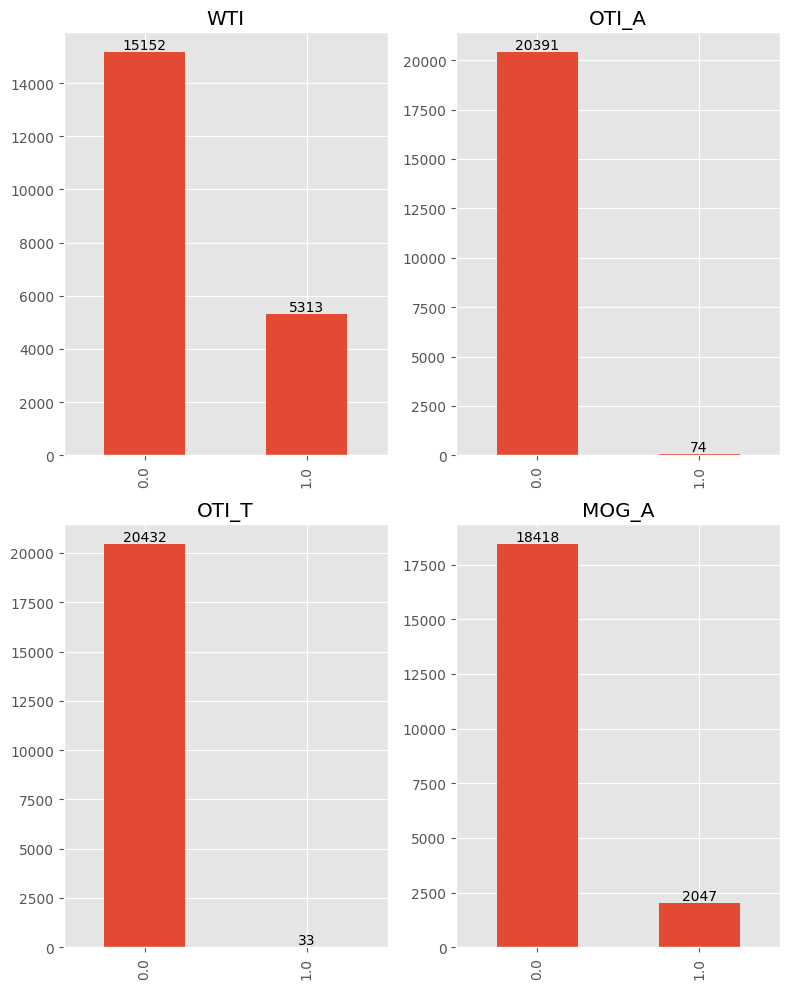

In [10]:
fig, axs = plt.subplots(2,2, figsize=(8,10))
axs = axs.flatten()
for targ, ax in zip(targets, axs):
    bar = df_merged[targ].value_counts().plot(ax=ax, kind='bar')
    for bar in ax.containers:
        ax.bar_label(bar)
    ax.set_title(targ)
plt.tight_layout()
plt.show()

### Bivariate

#### Correlations

C:\Users\samue\AppData\Local\Temp\ipykernel_3168\3694105500.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_merged.corr(), annot=True, cmap="coolwarm", fmt=".2f")


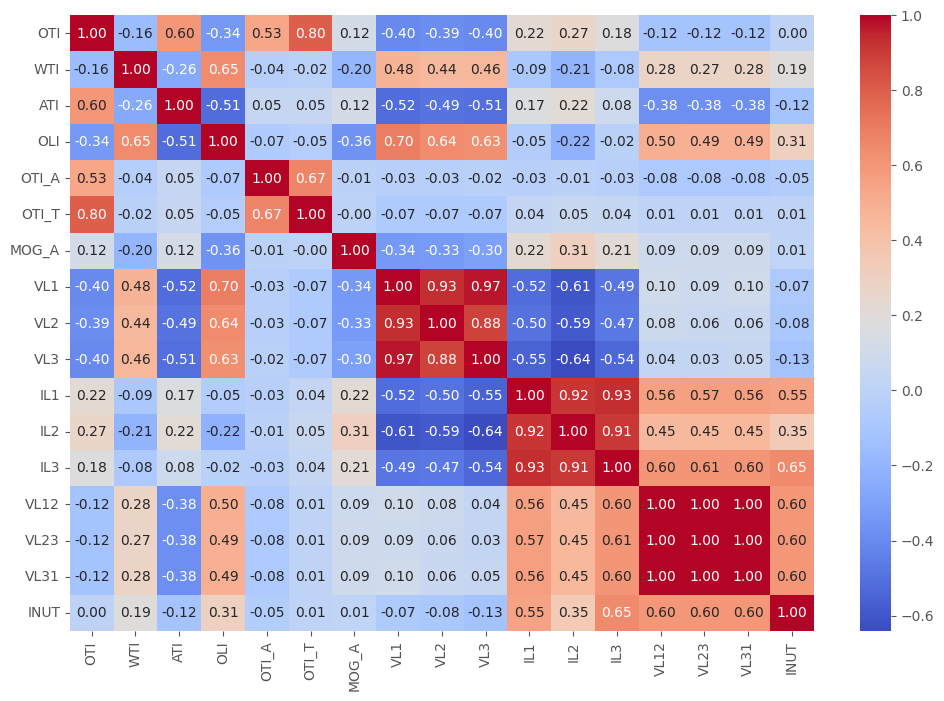

In [11]:
plt.figure(figsize=(12,8))
sns.heatmap(df_merged.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

C:\Users\samue\AppData\Local\Temp\ipykernel_3168\1018588120.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_merged.corr(), annot=True, cmap="coolwarm", fmt=".2f")


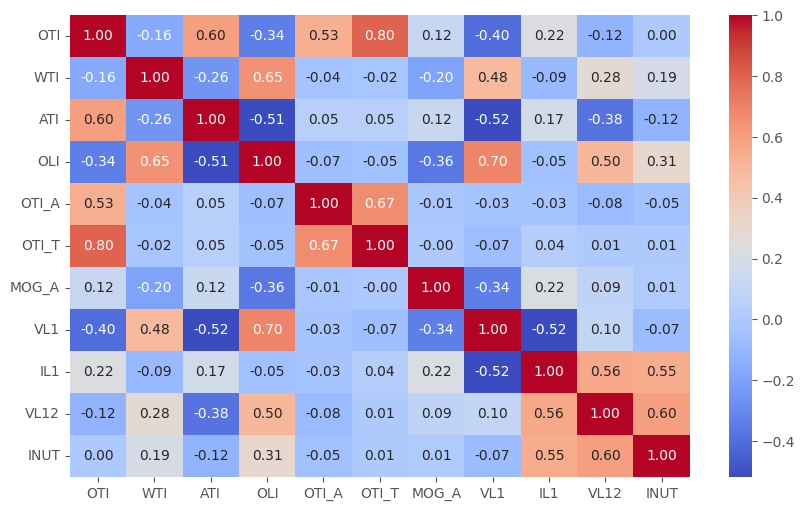

In [12]:
df_merged = df_merged.drop(columns=['VL2', 'VL3', 'IL2', 'IL3', 'VL23', 'VL31'])
plt.figure(figsize=(10,6))
sns.heatmap(df_merged.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

In [13]:
abs_corr = df_merged.corr()[['WTI', 'OTI_A', 'OTI_T', 'MOG_A']].abs()
abs_corr = abs_corr.sum(numeric_only=True, axis=0)
abs_corr

C:\Users\samue\AppData\Local\Temp\ipykernel_3168\1510295626.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  abs_corr = df_merged.corr()[['WTI', 'OTI_A', 'OTI_T', 'MOG_A']].abs()


WTI      3.360629
OTI_A    2.551076
OTI_T    2.702875
MOG_A    2.466733
dtype: float64

#### Target vs DeviceTimeStamp

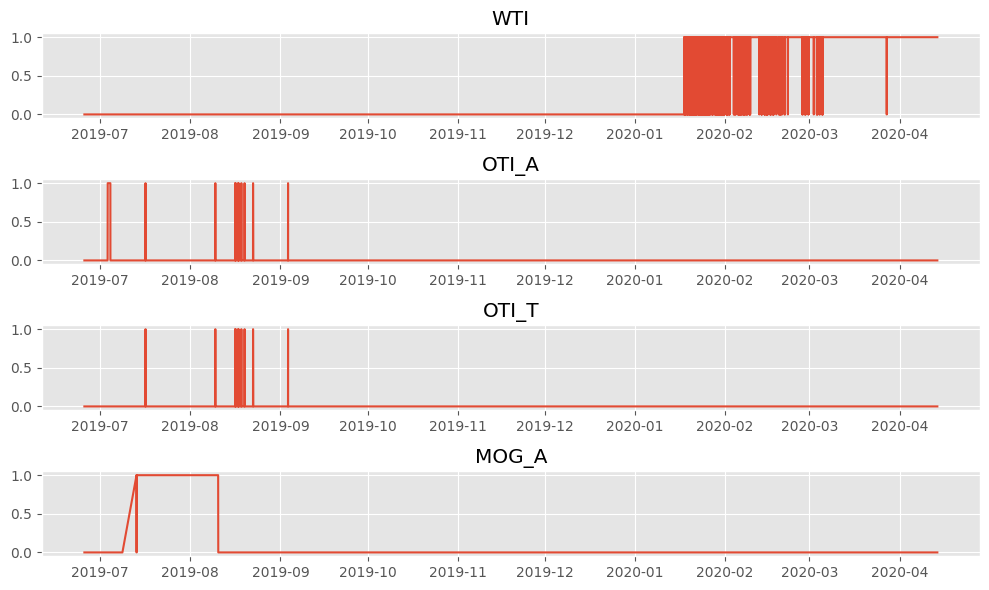

In [14]:
fig, axs = plt.subplots(4,1,figsize=(10, 6))
axs = axs.flatten()
for i, t in enumerate(zip(axs, targets)):
    ax = t[0]
    targ = t[1]
    ax.plot(df_merged['DeviceTimeStamp'], df_merged[targ], label=targ)
    ax.set_title(targ)
plt.tight_layout()
plt.show()

### Multivariate

### Summary

- Nearly duplicate columns were dropped, preventing **data leakage**
- WTI appears to have the greatest summation of absolute-valued correlations amongst the data
- The `OTI` columns appear to have a bias for each other, suggesting to drop those columns during model selection

## Model Selection

### Helper Functions/Constants

In [15]:
random_state = 42
clf = [
    SVC(random_state=random_state),
    DecisionTreeClassifier(random_state=random_state),
    AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1),
    RandomForestClassifier(random_state=random_state),
    ExtraTreesClassifier(random_state=random_state),
    GradientBoostingClassifier(random_state=random_state),
    MLPClassifier(random_state=random_state),
    KNeighborsClassifier(),
    LogisticRegression(random_state = random_state),
    LinearDiscriminantAnalysis(),
    XGBClassifier(),
    LGBMClassifier()
]
clf_names = [
    "SVC",
    "DecisionTree",
    "AdaBoost",
    "RandomForest",
    "ExtraTrees",
    "GradientBoosting",
    "MultipleLayerPerceptron",
    "KNeighbors",
    "LogisticRegression",
    "LinearDiscriminantAnalysis",
    "XGBoost",
    "LGBM",
]
classifiers = dict(zip(clf_names, clf))

In [16]:
def split_and_scale(target, to_drop: list[str] = []):
    X = df_merged.drop(['DeviceTimeStamp', target],axis=1)
    if len(to_drop) > 0:
        X = X.drop(to_drop, axis=1)
    y = df_merged[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=42)
    kfold = StratifiedKFold(n_splits=10)
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test, kfold

In [17]:
def cross_val(classifiers, X_train, y_train, kfold):
    cv_results = []
    for classifier in classifiers.values():
        cv_score = cross_val_score(classifier, X_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=4)
        cv_results.append(cv_score)

    cv_means = [i.mean() for i in cv_results]
    cv_std = [i.std() for i in cv_results]
    cv_res = pd.DataFrame({
        "CrossValMeans": cv_means, 
        "CrossValerrors": cv_std, 
        "Algorithm": classifiers.keys()
    })
    return cv_results, cv_means, cv_std, cv_res

In [18]:
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.3f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.3f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

In [19]:
def plot_mean_accuracy(cv_res, cv_std, target):
    _, ax = plt.subplots(figsize=(8, 6))
    g = sns.barplot(ax=ax, data=cv_res, x="CrossValMeans", y="Algorithm", palette="Set3", orient = "h",**{'xerr': cv_std})
    g.set_xlabel("Mean Accuracy")
    g.set_title(target + " Cross validation scores")
    show_values(g, "h", space=0)

In [20]:
def model_test(model, parameters, X_train, X_test, y_train, y_test):
    classifiers[model] = GridSearchCV(classifiers[model], parameters, cv=5, verbose=1, n_jobs=6)
    start = time.time()
    classifiers[model].fit(X_train, y_train)
    stop = time.time()
    print(f"Training time: {stop - start:.2f}s")
    print(f"Best parameters: {classifiers[model].best_params_}")
    y_hat = classifiers[model].predict(X_test)
    cfm = confusion_matrix(y_test, y_hat)
    print(f'Confusion Matrix: \n{cfm}')
    print(f'{model}: {accuracy_score(y_test, y_hat)*100 :.2f}%')
    print(f"{classification_report(y_test, y_hat)}")

### Model Selection

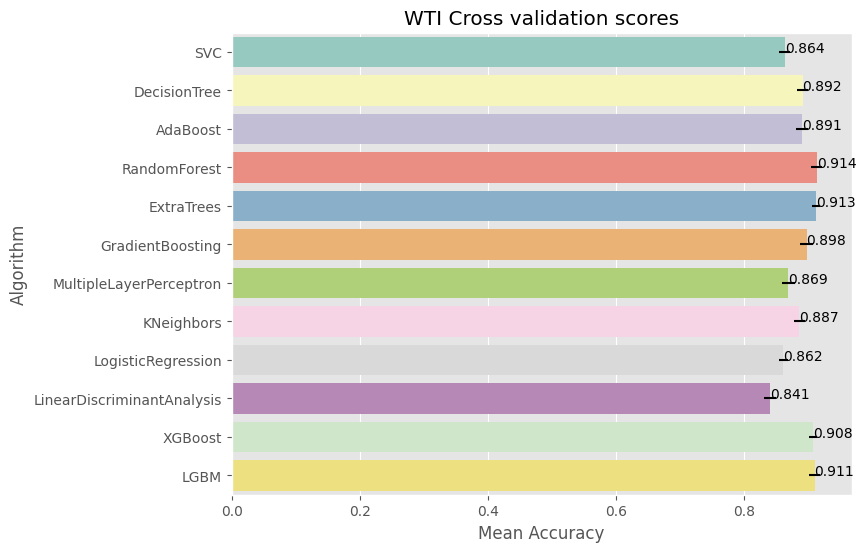

In [21]:
target = 'WTI'
X_train, X_test, y_train, y_test, kfold = split_and_scale(target)
cv_results, cv_means, cv_std, cv_res = cross_val(classifiers=classifiers, X_train=X_train, y_train=y_train, kfold=kfold)
plot_mean_accuracy(cv_res=cv_res, cv_std=cv_std, target=target)

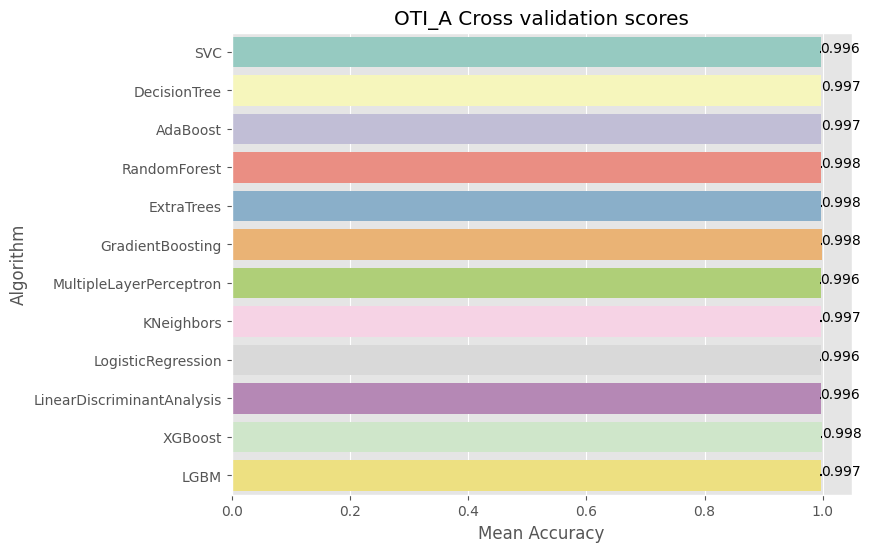

In [22]:
target = 'OTI_A'
X_train, X_test, y_train, y_test, kfold = split_and_scale(target, ['OTI_T', 'OTI'])
cv_results, cv_means, cv_std, cv_res = cross_val(classifiers=classifiers, X_train=X_train, y_train=y_train, kfold=kfold)
plot_mean_accuracy(cv_res=cv_res, cv_std=cv_std, target=target)

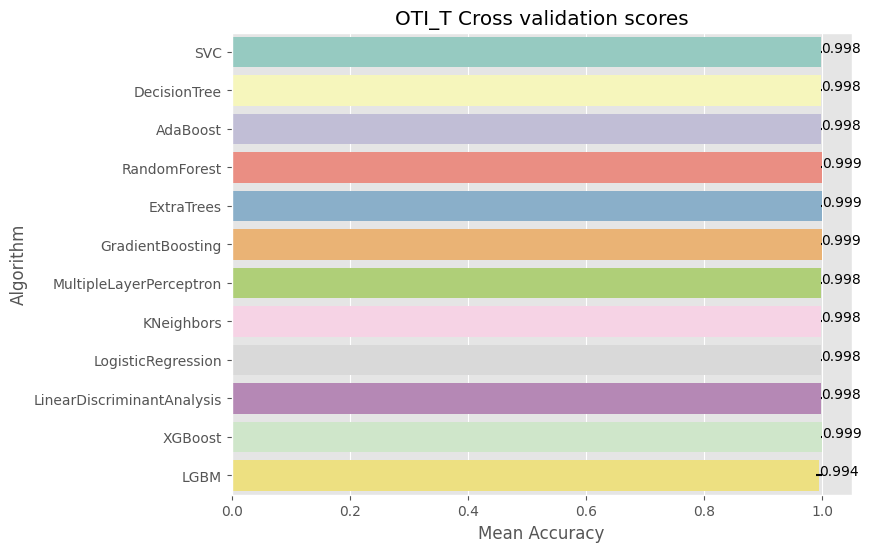

In [23]:
target = 'OTI_T'
X_train, X_test, y_train, y_test, kfold = split_and_scale(target, ['OTI_A', 'OTI'])
cv_results, cv_means, cv_std, cv_res = cross_val(classifiers=classifiers, X_train=X_train, y_train=y_train, kfold=kfold)
plot_mean_accuracy(cv_res=cv_res, cv_std=cv_std, target=target)

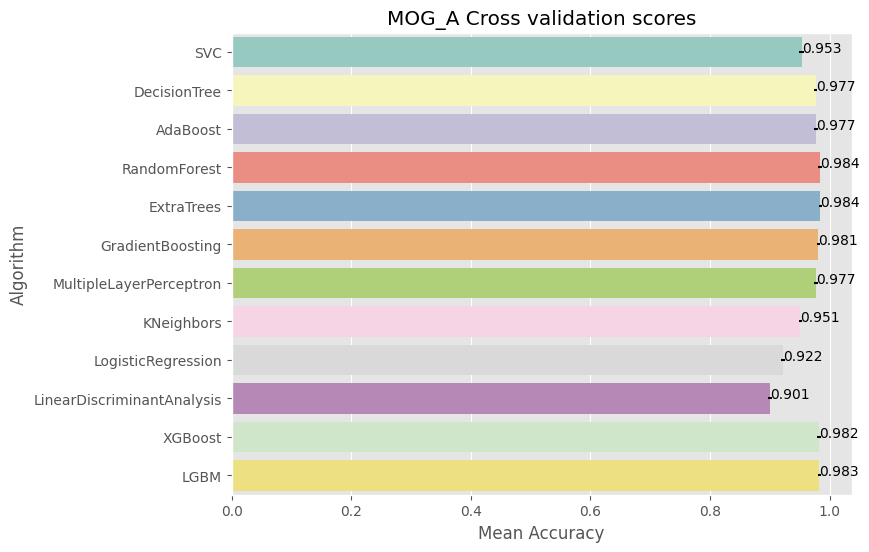

In [24]:
target = 'MOG_A'
X_train, X_test, y_train, y_test, kfold = split_and_scale(target)
cv_results, cv_means, cv_std, cv_res = cross_val(classifiers=classifiers, X_train=X_train, y_train=y_train, kfold=kfold)
plot_mean_accuracy(cv_res=cv_res, cv_std=cv_std, target=target)

In [42]:
clf = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    ExtraTreesClassifier(),
    GradientBoostingClassifier(),
    XGBClassifier(),
    LGBMClassifier(),
]
clf_names = [
    'DecisionTree',
    'RandomForest',
    'ExtraTrees',
    'GradientBoosting',
    'XGBoost',
    'LGBM'
]
X_train, X_test, y_train, y_test, kfold = split_and_scale('WTI')

## Modeling and Predictions

### Model Training

In [43]:
classifiers = dict(zip(clf_names, clf))
classifiers.keys()

dict_keys(['DecisionTree', 'RandomForest', 'ExtraTrees', 'GradientBoosting', 'XGBoost', 'LGBM'])

In [31]:
# Decision Tree
model = 'DecisionTree'
parameters = {
    'max_depth': [55, 89, None],
    'max_leaf_nodes': [233, 377, None],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 3]
}
model_test(model, parameters=parameters, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Training time: 4.60s
Best parameters: {'max_depth': 55, 'max_leaf_nodes': 233, 'min_samples_leaf': 1, 'min_samples_split': 3}
Confusion Matrix: 
[[4182  404]
 [ 222 1332]]
DecisionTree: 89.80%
              precision    recall  f1-score   support

         0.0       0.95      0.91      0.93      4586
         1.0       0.77      0.86      0.81      1554

    accuracy                           0.90      6140
   macro avg       0.86      0.88      0.87      6140
weighted avg       0.90      0.90      0.90      6140



In [32]:
# Extra Trees
model = 'ExtraTrees'
parameters = {
    'n_estimators': [100, 1000, 1500, 2000],
}
model_test(model, parameters=parameters, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Training time: 44.91s
Best parameters: {'n_estimators': 1000}
Confusion Matrix: 
[[4218  368]
 [ 175 1379]]
ExtraTrees: 91.16%
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94      4586
         1.0       0.79      0.89      0.84      1554

    accuracy                           0.91      6140
   macro avg       0.87      0.90      0.89      6140
weighted avg       0.92      0.91      0.91      6140



In [33]:
# Gradient Boosting
model = 'GradientBoosting'
parameters = {
    'min_samples_split': [1, 2, 3, 5, 8],
    'learning_rate': [0.0001, 0.001, 0.1, 0.2, 0.3, 0.5, 0.8],
    'subsample': np.arange(0.1, 1.1, 0.2),
}
model_test(model, parameters=parameters, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

Fitting 5 folds for each of 175 candidates, totalling 875 fits
Training time: 1668.14s
Best parameters: {'learning_rate': 0.2, 'min_samples_split': 2, 'subsample': 0.9000000000000001}
Confusion Matrix: 
[[4139  447]
 [ 192 1362]]
GradientBoosting: 89.59%
              precision    recall  f1-score   support

         0.0       0.96      0.90      0.93      4586
         1.0       0.75      0.88      0.81      1554

    accuracy                           0.90      6140
   macro avg       0.85      0.89      0.87      6140
weighted avg       0.90      0.90      0.90      6140



In [34]:
# XGBoost 
model = 'XGBoost'
parameters = {
    'n_estimators': [100, 1000, 1500, 2000],
    'learning_rate': [0.0001, 0.001, 0.1, 0.2, 0.3, 0.5, 0.8]
}
model_test(model, parameters=parameters, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
Training time: 220.52s
Best parameters: {'learning_rate': 0.1, 'n_estimators': 100}
Confusion Matrix: 
[[4156  430]
 [ 158 1396]]
XGBoost: 90.42%
              precision    recall  f1-score   support

         0.0       0.96      0.91      0.93      4586
         1.0       0.76      0.90      0.83      1554

    accuracy                           0.90      6140
   macro avg       0.86      0.90      0.88      6140
weighted avg       0.91      0.90      0.91      6140



In [44]:
# LightGBM
model = 'LGBM'
parameters = {
    'n_estimators': [25, 50, 75, 100, 1000],
    'learning_rate': [0.0001, 0.001, 0.1, 0.2, 0.3, 0.5, 0.8],
}
model_test(model, parameters=parameters, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

Fitting 5 folds for each of 35 candidates, totalling 175 fits
Training time: 9.09s
Best parameters: {'learning_rate': 0.2, 'n_estimators': 50}
Confusion Matrix: 
[[4203  383]
 [ 181 1373]]
LGBM: 90.81%
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94      4586
         1.0       0.78      0.88      0.83      1554

    accuracy                           0.91      6140
   macro avg       0.87      0.90      0.88      6140
weighted avg       0.91      0.91      0.91      6140



### Hypertuning

In [45]:
parameters = {
    'n_estimators': np.arange(500, 1500, 100),
    'min_samples_split': [2, 5, 8, 13],
    'min_samples_leaf': [1, 2, 5, 8],
}
model = ExtraTreesClassifier(random_state=42)
clf = GridSearchCV(model, parameters, cv=5, verbose=1, n_jobs=6)
start = time.time()
clf.fit(X_train, y_train)
stop = time.time()
print(f"Training time: {stop - start:.2f}s")
print(f"Best parameters: {clf.best_params_}")

Fitting 5 folds for each of 160 candidates, totalling 800 fits
Training time: 898.78s
Best parameters: {'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 600}


In [46]:
y_hat = clf.predict(X_test)
cfm = confusion_matrix(y_test, y_hat)
print(f'Confusion Matrix: \n{cfm}')
print(f'Accuracy: {accuracy_score(y_test, y_hat)*100 :.2f}%')
print(f"{classification_report(y_test, y_hat)}")

Confusion Matrix: 
[[4202  384]
 [ 155 1399]]
Accuracy: 91.22%
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94      4586
         1.0       0.78      0.90      0.84      1554

    accuracy                           0.91      6140
   macro avg       0.87      0.91      0.89      6140
weighted avg       0.92      0.91      0.91      6140



### Export

In [49]:
pickle.dump(clf, open('model.pkl', 'wb'))

### Summary

- Best target: *WTI*
  - No failure : Failure = ~3:1
- Model with greatest mean accuracy: *Extra Trees Classifier*
